In [1]:
import os
from glob import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

/misc/me/pratikm/virtualEnv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Global variables

In [3]:
DIR_TFRECORDS = 'data_small_tfrecords'
DATA_TRAIN = glob('./'+DIR_TFRECORDS+'/*.tfrecords')

ANCHORS = np.array(
    [
        [1.73145, 1.3221],
        [4.00944, 3.19275],
        [8.09892, 5.05587],
        [4.84053, 9.47112],
        [10.0071, 11.2364]
    ]
)
NUM_ANCHORS = ANCHORS.shape[0]
MAX_OBJECTS = 10  # check later (ensure it matches with writing file)
NUM_OBJECTS = 20

GRID_SIZE = 32
GRID_H, GRID_W = 19, 19
IMG_H, IMG_W = 608, 608  # GRID_H * GRID_SIZE = 19 * 32 = 608
THRESHOLD_IOU = 0.5
SCALE_LOSS_CONFIDENCE_OBJECT_PRESENT = 5
THRESHOLD_OUT_PROB = 0.5
THRESHOLD_IOU_NMS = 0.5

NUM_EPOCHS = 10
BATCH_SIZE = 64
MODEL_DIR = 'model'

## Yolo Loss function

In [4]:
def get_mapped_output(output):
    anchors = tf.cast(tf.reshape(ANCHORS, [1, 1, 1, ANCHORS.shape[0], 2]), dtype=tf.float32)  # try using variable for ANCHORS
    
    # create cartesian grid on output space
    coordinates_y = tf.range(GRID_H)
    coordinates_x = tf.range(GRID_W)
    x, y = tf.meshgrid(coordinates_x, coordinates_y)
    x = tf.reshape(x, [-1])
    y = tf.reshape(y, [-1])
    coordinates = tf.stack([y, x], 1)
    coordinates = tf.reshape(coordinates, [1, GRID_H, GRID_W, 1, 2])
    coordinates = tf.cast(coordinates, tf.float32)
    
    # change dimensions of tensors for broadcasting
    output = tf.reshape(output, [-1, GRID_H, GRID_W, ANCHORS.shape[0], 5+NUM_OBJECTS])
    shape = tf.cast(tf.reshape(tf.shape(output)[1:3], [1, 1, 1, 1, 2]), tf.float32)
    
    # map output to input space (also split yx, hw, prob_obj, prob_class)
    out_yx = tf.sigmoid(output[..., :2])  # sigmoid to keep centers in interval [0,1]
    out_hw = tf.exp(output[..., 2:4])  # exp to keep values positive
    out_yx = (out_yx + coordinates) / shape  # maps values to [0,1] input image space
    out_hw = out_hw * anchors / shape
    
    # get corresponding probabilities
    out_prob_obj = tf.sigmoid(output[..., 4:5])
    out_prob_class = tf.nn.softmax(output[..., 5:])
    
    return out_yx, out_hw, out_prob_obj, out_prob_class
    

def get_iou(out_yx, out_hw, targets):
    # out_yx.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 2]
    # targets.shape = [BATCH_SIZE, MAX_OBJECTS, 5]
    
    # compute ious for each anchor in each grid in axis=4
    out_yx = tf.expand_dims(out_yx, 4)
    out_hw = tf.expand_dims(out_hw, 4)
    out_min = out_yx - out_hw/2.
    out_max = out_yx + out_hw/2.
    
    targets = tf.reshape(targets, [tf.shape(targets)[0], 1, 1, 1, MAX_OBJECTS, 5])
    targets_yx = targets[..., 0:2]
    targets_hw = targets[..., 2:4]
    
    targets_min = targets_yx - targets_hw/2.
    targets_max = targets_yx + targets_hw/2.
    
    intersection_min = tf.maximum(out_min, targets_min)
    intersection_max = tf.minimum(out_max, targets_max)
    intersection_hw = tf.maximum(intersection_max - intersection_min, 0.)
    area_intersection = intersection_hw[..., 0] * intersection_hw[..., 1]
    
    area_out = out_hw[...,0] * out_hw[...,1]
    area_targets = targets[...,0] * targets[...,1]
    area_union = area_targets + area_out - area_intersection
    iou = area_intersection / area_union
    
    return iou
    

def get_confidence_loss(out_flag_object, flag_object, out_prob_obj):
    mask_object_absent = (1 - out_flag_object) * (1 - flag_object)
    loss_object_absent = mask_object_absent * tf.square(out_prob_obj)
    
    loss_object_present = flag_object * tf.square(1-out_prob_obj)
    return loss_object_absent + SCALE_LOSS_CONFIDENCE_OBJECT_PRESENT*loss_object_present
    
def get_classification_loss(flag_object, box_adjustments, out_prob_class):
    classes = tf.cast(box_adjustments[...,4], tf.int32)
    classes = tf.one_hot(classes, NUM_OBJECTS)
    
    loss_classification = flag_object * tf.square(classes - out_prob_class)
    
    return loss_classification

def get_regression_loss(out_box_adjustments, flag_object, box_adjustments):
    loss_regression = flag_object * tf.square(box_adjustments[...,:4] - out_box_adjustments)
    
    return loss_regression
    
def get_loss(output, targets, flag_object, box_adjustments):
    # output.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 5+NUM_OBJECTS]
    # targets.shape = [BATCH_SIZE, MAX_OBJECTS, 5]
    # flag_object.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 1]
    # box_adjustments.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 5]

    # map output (from CNN) to input image space i.e. [0,1]
    out_yx, out_hw, out_prob_obj, out_prob_class = get_mapped_output(output)
    
    # get iou for all boxes wrt each anchor box in each grid
    iou = get_iou(out_yx, out_hw, targets)
    
    # keep best bbox for each anchor for each grid as per iou
    iou_best = tf.reduce_max(iou, axis=4, keepdims=True)
    
    # threshold over ious
    out_flag_object = tf.cast(iou_best > THRESHOLD_IOU, tf.float32)
    
    # object presence loss (confidence)
    loss_confidence = get_confidence_loss(out_flag_object, flag_object, out_prob_obj)
    
    # classification loss
    loss_classification = get_classification_loss(flag_object, box_adjustments, out_prob_class)
    
    # regression loss
    out_box_adjustments = tf.concat([tf.sigmoid(output[...,0:2]), output[...,2:4]], axis=-1)
    loss_regression = get_regression_loss(out_box_adjustments, flag_object, box_adjustments)
    
    # accumulate loss
    loss_confidence_sum = tf.reduce_sum(loss_confidence)
    loss_classification_sum = tf.reduce_sum(loss_classification)
    loss_regression_sum = tf.reduce_sum(loss_regression)
    
    loss = tf.cast(1/tf.shape(targets)[0], tf.float32) * 0.5 * (loss_confidence_sum + loss_classification_sum + loss_regression_sum)
    
    
    return loss

## Post-processing

In [5]:
def center2corner(out_yx, out_hw):
    # out_yx.shape = [GRID_H, GRID_W, NUM_ANCHORS, 2]
    
    box_min = out_yx - (out_hw/2.)
    box_max = out_yx + (out_hw/2.)
    
    out_corners = tf.concat([box_min[...,0:1], box_min[...,1:2], box_max[...,0:1], box_max[...,1:2]], axis=-1)
    return out_corners

def get_filtered_output(map_params):
    # this is done to use batch 
    out_corners, out_prob_obj, out_prob_class = map_params[0], map_params[1], map_params[2]
    
    # compute overall prob for each anchor in each grid
    out_prob = out_prob_obj * out_prob_class
    
    # get max prob among all classes at each anchor in each grid
    class_max = tf.argmax(out_prob, axis=-1)
    prob_class = tf.reduce_max(out_prob, axis=-1)
    
    # compute filter mask
    mask_filter = prob_class >= THRESHOLD_OUT_PROB
    
    # apply mask on output
    box_filtered = tf.boolean_mask(out_corners, mask_filter)
    prob_filtered = tf.boolean_mask(prob_class, mask_filter)
    class_filtered = tf.boolean_mask(class_max, mask_filter)
    return box_filtered, prob_filtered, class_filtered

def get_predictions(output):
    # output.shape = [BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 5+20]
    
    # split output
    out_yx, out_hw, out_prob_obj, out_prob_class = get_mapped_output(output)
    
    # convert boxes from center coordinates to corner coordinates
    out_corners = center2corner(out_yx, out_hw)
    
    # filter output (needs to be done separately for each image in batch)
    box_filtered, prob_filtered, class_filtered = tf.map_fn(
        get_filtered_output, 
        (out_corners, out_prob_obj, out_prob_class),
        dtype=(tf.float32, tf.float32, tf.int64)
    )
    
    # scale boxes from [0,1] to image space
    img_space = tf.reshape(tf.cast(tf.stack([IMG_H, IMG_W, IMG_H, IMG_W]), tf.float32), [1, 1, 4])
    box_filtered = box_filtered * img_space
    
    # perform non-max suppression
    max_objects = tf.ones(tf.shape(box_filtered)[0], dtype=tf.int32) * MAX_OBJECTS
    box_nms_indices = tf.map_fn(lambda x: tf.image.non_max_suppression(x[0], x[1], x[2], THRESHOLD_IOU_NMS), (box_filtered, prob_filtered, max_objects), dtype=tf.int32)
    box_nms = tf.map_fn(lambda x: tf.gather(x[0], x[1]), (box_filtered, box_nms_indices), dtype=tf.float32)
    prob_nms = tf.map_fn(lambda x: tf.gather(x[0], x[1]), (prob_filtered, box_nms_indices), dtype=tf.float32)
    class_nms = tf.map_fn(lambda x: tf.gather(x[0], x[1]), (class_filtered, box_nms_indices), dtype=tf.int64)
    
    return box_nms, prob_nms, class_nms

## Estimator

In [7]:
def parse_record(record):
    # dictionary as per saved TFRecord
    keys_to_features = {
        'img': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'targets': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'flag_object': tf.FixedLenFeature(shape=(), dtype=tf.string),
        'box_adjustments': tf.FixedLenFeature(shape=(), dtype=tf.string)
    }

    # parse record
    parsed = tf.parse_single_example(record, keys_to_features)

    # decode image
    img = tf.decode_raw(parsed['img'], tf.float32)
    img = tf.reshape(img, [IMG_H, IMG_W, 3])

    # decode label
    targets = tf.decode_raw(parsed['targets'], tf.float32)
    targets = tf.reshape(targets, [MAX_OBJECTS, 5])

    # decode other matrices
    flag_object = tf.decode_raw(parsed['flag_object'], tf.float32)
    flag_object = tf.reshape(flag_object, [GRID_H, GRID_W, ANCHORS.shape[0], 1])
    box_adjustments = tf.decode_raw(parsed['box_adjustments'], tf.float32)
    box_adjustments = tf.reshape(box_adjustments, [GRID_H, GRID_W, ANCHORS.shape[0], 5])

    return {'img': img}, targets, flag_object, box_adjustments

def input_fn_train(data_file):    
    # dataset processing
    dataset = tf.data.TFRecordDataset(data_file)
    
    dataset = dataset.map(parse_record)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    
    iterator = dataset.make_one_shot_iterator()
    features, targets, flag_object, box_adjustments = iterator.get_next()
    
    return features, {'targets': targets, 'flag_object': flag_object, 'box_adjustments': box_adjustments}

def input_fn_predict(data_file):    
    # dataset processing
    dataset = tf.data.TFRecordDataset(data_file)
    
    dataset = dataset.map(parse_record)
    dataset = dataset.batch(BATCH_SIZE)
    
    iterator = dataset.make_one_shot_iterator()
    features, targets, flag_object, box_adjustments = iterator.get_next()
    
    return features, {'targets': targets, 'flag_object': flag_object, 'box_adjustments': box_adjustments}

def get_feature_columns():
    img = tf.feature_column.numeric_column('img', dtype=tf.float32)
    
    return img

def model_fn(features, labels, mode, params):
    # input layer
    features = tf.feature_column.input_layer(features, params['feature_columns'])
    imgs = tf.reshape(features, [-1, IMG_H, IMG_W, 3])
    # imgs.shape = (BATCH_SIZE, 608, 608, 3)
    
    # CNN
    with tf.name_scope('CNN'):
        x = tf.layers.conv2d(imgs, filters=8, kernel_size=5, activation=tf.nn.relu, padding='same')
        x = tf.layers.max_pooling2d(x, pool_size=4, strides=4)
        # x.shape = (BATCH_SIZE, 152, 152, 8)

        x = tf.layers.conv2d(x, filters=64, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.max_pooling2d(x, pool_size=4, strides=4)
        # x.shape = (BATCH_SIZE, 38, 38, 64)

        x = tf.layers.conv2d(x, filters=125, kernel_size=3, activation=tf.nn.relu, padding='same')
        x = tf.layers.max_pooling2d(x, pool_size=2, strides=2)
        # x.shape = (BATCH_SIZE, 19, 19, 125)

        output = tf.reshape(x, (-1, GRID_H, GRID_W, params['num_anchors'], 5+params['num_objects']))
        # output.shape = (BATCH_SIZE, 19, 19, 5, 25)
    
    ## PREDICT
    if mode == tf.estimator.ModeKeys.PREDICT:
        with tf.name_scope('post_processing'):
            box_nms, prob_nms, class_nms = get_predictions(output)
        outputs = {
            'img': imgs,
            'box': box_nms,
            'prob': prob_nms,
            'class': class_nms
        }
        return tf.estimator.EstimatorSpec(mode, predictions=outputs)
    
    # compute loss
    with tf.name_scope('Loss'):
        loss = get_loss(output, labels['targets'], labels['flag_object'], labels['box_adjustments'])
    tf.summary.scalar('loss_summary', loss)
    
    ## EVALUATE
#     # compute evaluation metrics
#     mse = tf.metrics.mean_squared_error(labels=labels, predictions=predictions, name='mse_op')
#     metrics = {'mse': mse}
#     tf.summary.scalar('mse', mse[1])
#     if mode == tf.estimator.ModeKeys.EVAL:
#         return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)
    
    ## TRAIN
    assert mode == tf.estimator.ModeKeys.TRAIN
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

## Model

In [8]:
# get feature columns
feature_columns = get_feature_columns()

# training configuration
run_config = tf.estimator.RunConfig().replace(keep_checkpoint_max=1, save_summary_steps=10)

# define model
model = tf.estimator.Estimator(
    model_fn=model_fn,
    params={
        'feature_columns': feature_columns,
        'num_anchors': ANCHORS.shape[0],
        'num_objects': NUM_OBJECTS
    },
    model_dir=MODEL_DIR,
    config=run_config
)

INFO:tensorflow:Using config: {'_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0fe537d630>, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_task_type': 'worker', '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 1, '_log_step_count_steps': 100, '_service': None, '_tf_random_seed': None, '_global_id_in_cluster': 0, '_task_id': 0, '_num_worker_replicas': 1, '_is_chief': True, '_session_config': None, '_num_ps_replicas': 0, '_model_dir': 'model', '_keep_checkpoint_every_n_hours': 10000}


## Train

In [9]:
model.train(input_fn=lambda: input_fn_train(DATA_TRAIN), steps=NUM_EPOCHS)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into model/model.ckpt.
INFO:tensorflow:step = 1, loss = 221.61551
INFO:tensorflow:Saving checkpoints for 10 into model/model.ckpt.
INFO:tensorflow:Loss for final step: 210.4111.


## Predict

In [10]:
predictions = model.predict(input_fn=lambda: input_fn_predict(DATA_TRAIN))

for p in predictions:
    i, b, p, c = p['img'], p['box'], p['prob'], p['class']

print(p.shape)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
(0,)


## Utility functions

In [37]:
def draw_boxes(img, box, prob, class_idx):
    # img: normalized ([-1,1]) image with shape [IMG_H, IMG_W, 3]
    
    # unnormalize image
    img = Image.fromarray(np.floor((img+1.)/2. * 255).astype(np.uint8))  # TODO: add 0.5 if needed
        
    # get color and font for annotation
    # TODO: later
    
    for idx in range(box.shape[0]):
        draw = ImageDraw.Draw(img)
        top, left, bottom, right = box[idx]
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(IMG_H, np.floor(bottom + 0.5).astype('int32'))
        right = min(IMG_W, np.floor(right + 0.5).astype('int32'))
        
        
        draw.rectangle([left, top, right, bottom])
        del draw
    
    return np.array(img)

In [26]:
d = draw_boxes(i, b, p, c)

In [27]:
b

array([[191.1079  , 130.30083 , 672.892   , 349.6992  ],
       [-31.54683 , 448.732   , 511.54688 , 671.268   ],
       [-65.23311 , -98.114586, 289.23312 , 130.1146  ],
       [295.85718 , -70.66481 , 632.1428  , 102.66482 ],
       [-15.317216, 286.92078 , 119.32137 , 389.08875 ],
       [242.1661  , 373.91922 , 301.8339  , 426.66714 ],
       [ 52.296803, 215.274   , 107.7032  , 268.3392  ],
       [305.0616  , 376.68103 , 366.93835 , 424.65585 ],
       [434.76373 , 374.7088  , 493.2363  , 427.70358 ],
       [ 84.2968  , 153.58969 , 139.7032  , 201.18507 ]], dtype=float32)

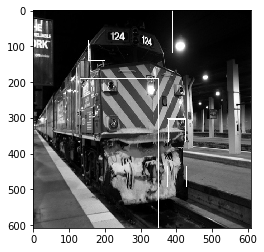

In [28]:
plt.imshow(d)
plt.show()

In [11]:
# tf.reset_default_graph()
# output = tf.random_normal([BATCH_SIZE, GRID_H, GRID_W, NUM_ANCHORS, 5+20])
# b, p, c = get_predictions(output)

# with tf.Session() as sess:
#     b, p, c = sess.run([b, p, c])

In [12]:
# tf.reset_default_graph()
# f, l = input_fn_train(DATA_TRAIN)

# with tf.Session() as sess:
#     f, l = sess.run([f,l])

# idx_in_batch = 0
# l = l['targets'][idx_in_batch]

# plt.imshow(f['img'][0,:,:,:])
# for idx_object in range(l.shape[0]):
#     plt.scatter((l[idx_object,1]-l[idx_object,3]/2)*IMG_W, (l[idx_object,0]-l[idx_object,2]/2)*IMG_H, color='w')
#     plt.scatter((l[idx_object,1]-l[idx_object,3]/2)*IMG_W, (l[idx_object,0]+l[idx_object,2]/2)*IMG_H, color='w')
#     plt.scatter((l[idx_object,1]+l[idx_object,3]/2)*IMG_W, (l[idx_object,0]-l[idx_object,2]/2)*IMG_H, color='w')
#     plt.scatter((l[idx_object,1]+l[idx_object,3]/2)*IMG_W, (l[idx_object,0]+l[idx_object,2]/2)*IMG_H, color='w')
# plt.show()